In [1]:
%%time

import os
import numpy as np
import torch
import random
import pytorch_lightning as pl
import cv2
import json

from PIL import Image
from torchvision import transforms
from typing import Dict

from tqdm.notebook import tqdm

import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from torchvision.transforms import Compose, Lambda
from torchvision.transforms._transforms_video import CenterCropVideo, NormalizeVideo

from pytorchvideo.data.encoded_video import EncodedVideo
from pytorchvideo.transforms import ApplyTransformToKey, ShortSideScale, UniformTemporalSubsample, UniformCropVideo

import matplotlib.pyplot as plt
%matplotlib inline

from CPD import datasets, loss, metrics, models

CPU times: user 1.42 s, sys: 480 ms, total: 1.9 s
Wall time: 1.48 s


### Fix GPU

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

### Fix random seeds

In [4]:
random.seed(123)
torch.manual_seed(123)

### Device

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Dataloader

In [6]:
class UCF_VIDEOS_DATASET(torch.utils.data.Dataset):
    def __init__(self, path_to_annotation, path_to_videos, seq_len):
        super(UCF_VIDEOS_DATASET, self).__init__()
        self.path_to_annotation = path_to_annotation
        self.path_to_videos = path_to_videos
        self.seq_len = seq_len
        
        self.annotation_array = []
        
        preprocess = transforms.Compose([transforms.ToTensor()])
        
        time_step = 3
        num_samles = 6
        num_attempts = 300
        
        self.data = []
        self.len = 0
        
        with open(path_to_annotation, 'r') as fp:
            for line in tqdm(fp):
                if line.split("  ")[1] == "Explosion":
                    self.annotation_array.append([line.split("  ")[0], 
                                                  int(line.split("  ")[2]), 
                                                  int(line.split("  ")[3]),
                                                  int(line.split("  ")[4])])
                    
                    cap = cv2.VideoCapture(os.path.join(self.path_to_videos, line.split("  ")[0]))
                    
                    count_ = 0
                    num_attempts_ = 0
                    nums_zeros = []
                    while count_ != num_samles:
                        num_attempts_ += 1
                        num_zeros = random.randint(1, self.seq_len-1)
                        if not num_zeros in nums_zeros:
                            frames_ones = [int(line.split("  ")[3]) + i*time_step for i in range(self.seq_len-num_zeros)]
                            frames_zeros = sorted([int(line.split("  ")[3]) - (i+1)*time_step for i in range(num_zeros)])
                            
                            if frames_zeros[0] >= int(line.split("  ")[2]) and frames_ones[-1] <= int(line.split("  ")[4]):
                                frames_all = np.append(frames_zeros, frames_ones)
                                sequence_labels = np.append(np.zeros(num_zeros), np.ones(self.seq_len-num_zeros))
                                sequence_imgs = []

                                for frame_id in frames_all:
                                    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
                                    ret, frame = cap.read()
                                    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                                    frame_pil = Image.fromarray(frame_rgb)
                                    sequence_imgs.append(preprocess(frame_pil))

                                sequence_imgs = torch.stack(sequence_imgs)
                                sequence_labels = torch.from_numpy(sequence_labels)
                                self.data.append([sequence_imgs, sequence_labels])

                                count_ += 1
                                nums_zeros.append(num_zeros)
                                self.len += 1
                            
                        if num_attempts_ == num_attempts:
                            break
                            
                if line.split("  ")[1] == "Normal":
                    self.annotation_array.append([line.split("  ")[0], 
                                                  int(line.split("  ")[2]), 
                                                  int(line.split("  ")[4])])
                    
                    cap = cv2.VideoCapture(os.path.join(self.path_to_videos, line.split("  ")[0]))
                    
                    num_zeros = self.seq_len
                    frames_all = sorted([int(line.split("  ")[4]) - i*time_step for i in range(num_zeros)])

                    if frames_zeros[0] >= int(line.split("  ")[2]):
                        sequence_labels = np.zeros(num_zeros)
                        sequence_imgs = []

                        for frame_id in frames_all:
                            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
                            ret, frame = cap.read()
                            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                            frame_pil = Image.fromarray(frame_rgb)
                            sequence_imgs.append(preprocess(frame_pil))

                        sequence_imgs = torch.stack(sequence_imgs)
                        sequence_labels = torch.from_numpy(sequence_labels)
                        self.data.append([sequence_imgs, sequence_labels])
                        self.len += 1
                        
                    frames_all = sorted([int(line.split("  ")[2]) + i*time_step for i in range(num_zeros)])

                    if frames_zeros[-1] <= int(line.split("  ")[5]):
                        sequence_labels = np.zeros(num_zeros)
                        sequence_imgs = []

                        for frame_id in frames_all:
                            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
                            ret, frame = cap.read()
                            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                            frame_pil = Image.fromarray(frame_rgb)
                            sequence_imgs.append(preprocess(frame_pil))

                        sequence_imgs = torch.stack(sequence_imgs)
                        sequence_labels = torch.from_numpy(sequence_labels)
                        self.data.append([sequence_imgs, sequence_labels])
                        self.len += 1

    def __len__(self):
        return self.len
        
    def __getitem__(self, item_idx):
        
        sequence_imgs = self.data[item_idx][0]
        sequence_labels = self.data[item_idx][1]
        
        return sequence_imgs, sequence_labels

In [8]:
%%time

seq_len = 16
path_to_videos = "data/explosion/"
path_annotation_train = "UCF_train.txt"
path_annotation_validation = "UCF_validation.txt"

imgs_dataset_train = UCF_VIDEOS_DATASET(path_annotation_train, 
                                        path_to_videos, 
                                        seq_len=seq_len)

imgs_dataset_validation = UCF_VIDEOS_DATASET(path_annotation_validation, 
                                             path_to_videos, 
                                             seq_len=seq_len)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

CPU times: user 35min 49s, sys: 8.97 s, total: 35min 58s
Wall time: 11min 10s


In [12]:
HIDDEN_LSTM = 16
HIDDEN_LSTM = 2048 * 7 * 7
HIDDEN_LSTM = 2048 * 8 * 10

class Combine(nn.Module):
    def __init__(self):
        super(Combine, self).__init__()
        # Pick a pretrained model and load the pretrained weights
        model_name = "slow_r50"
        self.extractor = torch.hub.load('facebookresearch/pytorchvideo:main', 'slow_r50', pretrained=True)
        # 5 for full cnn part
        self.extractor = nn.Sequential(*list(self.extractor.blocks[:5]))
        

        #self.rnn = nn.LSTM(
        #    input_size=2048 * 7 * 7,
        #    hidden_size=HIDDEN_LSTM, 
        #    num_layers=1,
        #    batch_first=True, 
        #    dropout=0.5)
        
        self.linear = nn.Linear(HIDDEN_LSTM, 1)      
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()  
        self.activation = nn.Sigmoid()        

    def forward(self, x):
        
        batch_size, timesteps, C, H, W = x.size()
        c_in = x.transpose(1, 2) 
        c_out = self.extractor(c_in) 
        r_in = c_out.transpose(1, 2).flatten(2)
        #print(c_out.shape)
        r_out = r_in
        #r_out, _ = self.rnn(r_in)
        r_out = self.dropout(self.linear(r_out))
        out = torch.sigmoid(r_out)
        return out    

### Pytorch Lightning

In [14]:
class CPD_model(pl.LightningModule):
    def __init__(
        self,
        model, 
        imgs_dataset_train,
        imgs_dataset_validation,
        batch_size: int = 16,
        seq_len: int = 16, 
        loss_type: str = 'bce',
        path_to_videos: str = "data/explosion/",
        path_annotation_train: str = "UCF_train.txt",
        path_annotation_validation: str = "UCF_validation.txt",
        
    ):
        super(CPD_model, self).__init__()

        self.model = model.to(self.device)
        self.batch_size = batch_size
        self.seq_len = seq_len
        
        if loss_type == 'bce':
            self.loss = nn.BCELoss()
        else:
            self.loss = loss.CPDLoss(len_segment=4)
            
        self.imgs_dataset_train = imgs_dataset_train
        self.imgs_dataset_validation = imgs_dataset_validation   
        
    def forward(self, inputs):
        return self.model(inputs)

    def training_step(self, batch, batch_idx):
        videos, labels = batch
        pred = self.forward(videos.float())

        train_loss = self.loss(pred.squeeze(), labels.float().squeeze())
        train_accuracy = ((pred.squeeze() > 0.5).long() == labels.squeeze()).float().mean()

        self.log('train_loss', train_loss, prog_bar=True, on_epoch=True)
        self.log('train_acc', train_accuracy, prog_bar=True, on_epoch=True)    
        
        return train_loss

    def validation_step(self, batch, batch_idx):
        videos, labels = batch
        pred = self.forward(videos.float())
        
        val_loss = self.loss(pred.squeeze(), labels.float().squeeze())      
        val_accuracy = ((pred.squeeze() > 0.5).long() == labels.squeeze()).float().mean()
                
        self.log('val_loss', val_loss, prog_bar=True)    
        self.log('val_acc', val_accuracy, prog_bar=True)    
        
        return {'val_loss': val_loss, 'val_acc': val_accuracy}
    

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.model.parameters(), lr=0.001) 
        return [opt]

    def train_dataloader(self):
        
        train_dataloader = DataLoader(self.imgs_dataset_train, batch_size=self.batch_size, shuffle=True, num_workers=4)
        return train_dataloader
        
    
    def val_dataloader(self):
        
        val_dataloader = DataLoader(self.imgs_dataset_validation, batch_size=self.batch_size, shuffle=False, num_workers=4)
        return val_dataloader

## Model CUSTOM loss

In [16]:
model_custom = Combine()

names = ['4.res_blocks.2.branch2.conv_c.weight', 
         '4.res_blocks.2.branch2.norm_c.weight',
         '4.res_blocks.2.branch2.norm_c.bias']

for name, param in model_custom.extractor.named_parameters():
    #if not name in names:
    param.requires_grad = False
        
model_custom_pl = CPD_model(model=model_custom,
                            imgs_dataset_train=imgs_dataset_train,
                            imgs_dataset_validation=imgs_dataset_validation,
                            batch_size=16, 
                            seq_len=16, 
                            loss_type='custom')    


running = 2

experiment_name = 'I3D_v{}'.format(running)
logger = pl.loggers.TensorBoardLogger(save_dir='logs/', name=experiment_name)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_acc',
    dirpath=f'logs/{experiment_name}',
    filename='{epoch:02d}-{val_acc:.3f}',
    mode='max')

checkpoint_callback_2 = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    dirpath=f'logs/{experiment_name}',
    filename='{epoch:02d}-{val_loss:.3f}',
    mode='min')


early_stop_callback = EarlyStopping(
   monitor='val_loss',
   min_delta=0.01,
   patience=20,
   verbose=True,
   mode='min'
)

trainer_custom = pl.Trainer(
    max_epochs=200, 
    gpus='0', 
    benchmark=True, 
    check_val_every_n_epoch=1, 
    logger=logger,
    callbacks=[checkpoint_callback, checkpoint_callback_2, early_stop_callback])    

Using cache found in /home/eromanenkova/.cache/torch/hub/facebookresearch_pytorchvideo_main
GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [17]:
%%time

trainer_custom.fit(model_custom_pl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type    | Params
----------------------------------
0 | model | Combine | 31.8 M
1 | loss  | CPDLoss | 0     
----------------------------------
163 K     Trainable params
31.6 M    Non-trainable params
31.8 M    Total params
127.193   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

CPU times: user 4.22 s, sys: 1.32 s, total: 5.55 s
Wall time: 8.21 s


/home/eromanenkova/anaconda3/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


### Model BCE

In [11]:
model_bce = Combine()

names = ['4.res_blocks.2.branch2.conv_c.weight', 
         '4.res_blocks.2.branch2.norm_c.weight',
         '4.res_blocks.2.branch2.norm_c.bias']

for name, param in model_bce.extractor.named_parameters():
    if not name in names:
        param.requires_grad = False
        
model_bce = CPD_model(model=model_bce,
                      imgs_dataset_train=imgs_dataset_train,
                      imgs_dataset_validation=imgs_dataset_validation,
                      batch_size=16, 
                      seq_len=16, 
                      loss_type='bce')    


running = 2

experiment_name = 'I3D_v{}'.format(running)
logger = pl.loggers.TensorBoardLogger(save_dir='logs/', name=experiment_name)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_acc',
    dirpath=f'logs/{experiment_name}',
    filename='{epoch:02d}-{val_acc:.3f}',
    mode='max')

checkpoint_callback_2 = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    dirpath=f'logs/{experiment_name}',
    filename='{epoch:02d}-{val_loss:.3f}',
    mode='min')


early_stop_callback = EarlyStopping(
   monitor='val_loss',
   min_delta=0.01,
   patience=20,
   verbose=True,
   mode='min'
)

Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


In [12]:
trainer_bce = pl.Trainer(
    max_epochs=200, 
    gpus='1', 
    benchmark=True, 
    check_val_every_n_epoch=1, 
    gradient_clip_val=0.5,
    logger=logger,
    callbacks=[checkpoint_callback, checkpoint_callback_2, early_stop_callback])  

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [13]:
%%time
trainer_bce.fit(model_bce)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]

  | Name  | Type    | Params
----------------------------------
0 | model | Combine | 31.8 M
1 | loss  | BCELoss | 0     
----------------------------------
1.2 M     Trainable params
30.6 M    Non-trainable params
31.8 M    Total params
127.193   Total estimated model params size (MB)


Metric val_loss improved. New best score: 3.648


Metric val_loss improved by 0.878 >= min_delta = 0.01. New best score: 2.771


Metric val_loss improved by 0.715 >= min_delta = 0.01. New best score: 2.055


Monitored metric val_loss did not improve in the last 20 records. Best score: 2.055. Signaling Trainer to stop.



CPU times: user 7min 36s, sys: 2min 35s, total: 10min 11s
Wall time: 10min 2s


In [14]:
threshold_number = 25
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]

In [15]:
model_bce.to('cuda')
(_, _, delay_list_bce, fp_delay_list_bce) = metrics.get_pareto_metrics_for_threshold(model_bce, 
                                                                             model_custom_pl.val_dataloader(), 
                                                                             threshold_list)

TP: 0, FP: 178, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 34, FP: 46, TN: 91, FN: 7, DELAY:0.3539325842696629, FP_DELAY:11.460674157303371
TP: 34, FP: 46, TN: 91, FN: 7, DELAY:0.3539325842696629, FP_DELAY:11.460674157303371
TP: 35, FP: 45, TN: 91, FN: 7, DELAY:0.39325842696629215, FP_DELAY:11.46629213483146
TP: 35, FP: 45, TN: 91, FN: 7, DELAY:0.39325842696629215, FP_DELAY:11.46629213483146
TP: 34, FP: 45, TN: 91, FN: 8, DELAY:0.398876404494382, FP_DELAY:11.47191011235955
TP: 35, FP: 44, TN: 91, FN: 8, DELAY:0.4101123595505618, FP_DELAY:11.47752808988764
TP: 36, FP: 43, TN: 91, FN: 8, DELAY:0.4550561797752809, FP_DELAY:11.48314606741573
TP: 36, FP: 43, TN: 91, FN: 8, DELAY:0.4550561797752809, FP_DELAY:11.48314606741573
TP: 36, FP: 43, TN: 91, FN: 8, DELAY:0.4550561797752809, FP_DELAY:11.48314606741573
TP: 36, FP: 43, TN: 91, FN: 8, DELAY:0.4550561797752809, FP_DELAY:11.48314606741573
TP: 36, FP: 43, TN: 91, FN: 8, DELAY:0.4550561797752809, FP_DELAY:11.48314606741573
TP: 36, FP: 43, TN:

In [16]:
model_custom_pl.to('cuda')
(_, _, delay_list, fp_delay_list) = metrics.get_pareto_metrics_for_threshold(model_custom_pl, 
                                                                             model_custom_pl.val_dataloader(), 
                                                                             threshold_list)

TP: 0, FP: 178, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 28, FP: 30, TN: 100, FN: 20, DELAY:0.9213483146067416, FP_DELAY:13.174157303370787
TP: 28, FP: 30, TN: 100, FN: 20, DELAY:0.9213483146067416, FP_DELAY:13.174157303370787
TP: 28, FP: 30, TN: 100, FN: 20, DELAY:0.9213483146067416, FP_DELAY:13.174157303370787
TP: 28, FP: 30, TN: 100, FN: 20, DELAY:0.9213483146067416, FP_DELAY:13.174157303370787
TP: 28, FP: 30, TN: 100, FN: 20, DELAY:0.9269662921348315, FP_DELAY:13.174157303370787
TP: 28, FP: 30, TN: 100, FN: 20, DELAY:0.9269662921348315, FP_DELAY:13.174157303370787
TP: 28, FP: 28, TN: 101, FN: 21, DELAY:0.949438202247191, FP_DELAY:13.241573033707866
TP: 28, FP: 28, TN: 101, FN: 21, DELAY:0.949438202247191, FP_DELAY:13.241573033707866
TP: 28, FP: 28, TN: 101, FN: 21, DELAY:0.949438202247191, FP_DELAY:13.241573033707866
TP: 28, FP: 28, TN: 101, FN: 21, DELAY:0.949438202247191, FP_DELAY:13.241573033707866
TP: 28, FP: 27, TN: 101, FN: 22, DELAY:0.9662921348314607, FP_DELAY:13.292134831

In [17]:
#np.save('fp_delay_list.npy', fp_delay_list)
#np.save('delay_list.npy', delay_list)

In [18]:
#fp_delay_list = np.load('fp_delay_list.npy')
#delay_list = np.load('delay_list.npy')

In [19]:
np.save('fp_delay_list.npy', fp_delay_list)
np.save('delay_list.npy', delay_list)
np.save('fp_delay_list_bce.npy', fp_delay_list_bce)
np.save('delay_list_bce.npy', delay_list_bce)

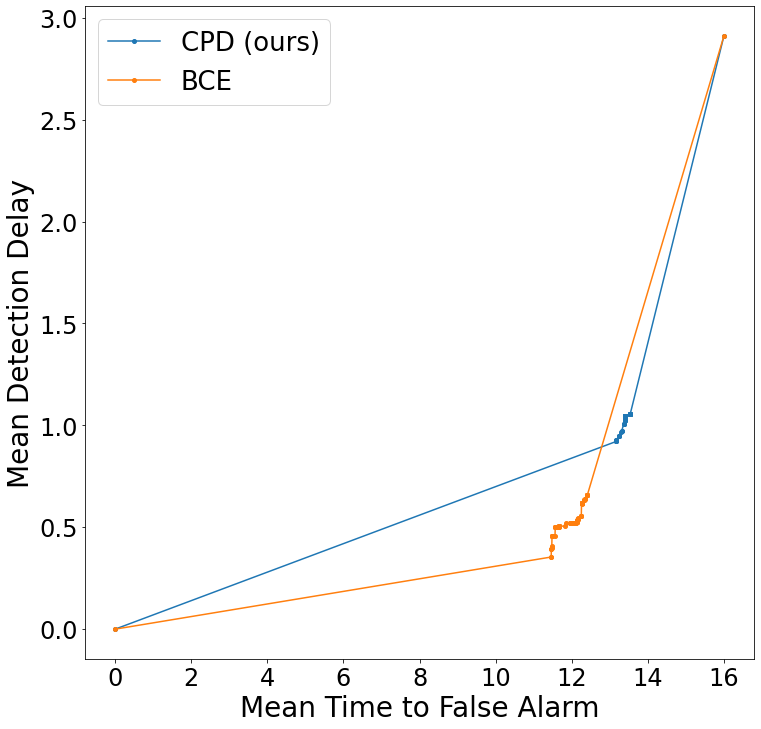

In [20]:
plt.figure(figsize=(12, 12))
plt.plot(fp_delay_list, delay_list, '-o', markersize=4, label='CPD (ours)')
plt.plot(fp_delay_list_bce, delay_list_bce, '-o', markersize=4, label='BCE')
#plt.plot(fp_delay_list_comb, delay_list_comb, '-o', markersize=4, label='Combined (ours)')

plt.xlabel('Mean Time to False Alarm', fontsize=28)
plt.ylabel('Mean Detection Delay', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(loc='upper left', fontsize=26);

In [21]:
quit()